In [1]:
import psycopg2
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline 
import pylab
pylab.rcParams['figure.figsize'] = (10, 5)

In [2]:
import os
MIMIC_PW = os.environ['PGPASSWORD'] 

In [3]:
conn = psycopg2.connect(database='mimic', 
        user='mimic', password=MIMIC_PW,
        host='grinder.inf.ethz.ch', port=5432)
cur = conn.cursor()

# 1. Diagnosis inspections

First add short title and long title for diagnose icd9 codes

In [4]:
cur.execute('''
    select distinct subject_id                                
    into temp sid_note from noteevents;''')

In [5]:
cur.execute('''
    select diagnoses_icd.* 
    into temp t_diagnoses
    from diagnoses_icd inner join sid_note on diagnoses_icd.subject_id=sid_note.subject_id
    order by subject_id, hadm_id, seq_num;''')

In [6]:
# cur.execute('''
#     select subject_id, hadm_id, seq_num, diagnoses_icd.icd9_code, short_title, long_title
#     into temp diagnoses
#     from diagnoses_icd inner join d_icd_diagnoses on diagnoses_icd.icd9_code = d_icd_diagnoses.icd9_code
#     order by subject_id, hadm_id, seq_num;
#     ''')

**How many different diagnoses?**

In [7]:
cur.execute('''
    select count(distinct icd9_code)
    from t_diagnoses;''')
N_UNIQUE_DIAG = cur.fetchone()[0]

In [8]:
cur.execute(' select count(*) from t_diagnoses;')
N_DIAGS = cur.fetchone()[0]

In [9]:
cur.execute('select count(distinct subject_id) from t_diagnoses;')
N_SUBJECTS = cur.fetchone()[0]

In [10]:
print '%d patients, %d distinct diagnoses, %d diagnoses in total' % (N_SUBJECTS, N_UNIQUE_DIAG, N_DIAGS)

46146 patients, 6977 distinct diagnoses, 646960 diagnoses in total


**Distribution of the diagnoses?**

In [11]:
cur.execute('''
    select icd9_code, count(*) as cnt
    from t_diagnoses
    group by icd9_code 
    order by cnt desc;''')

In [12]:
diag, cnt = zip( *cur.fetchall() )

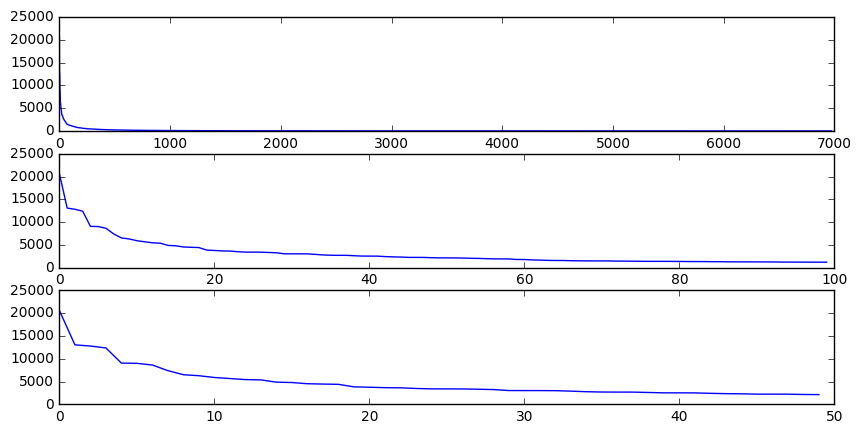

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharey=True)
ax1.plot(cnt)
ax2.plot(cnt[:100])
ax3.plot(cnt[:50])

In [16]:
ratio100, ratio50 = sum(cnt[:100]) *1.0 / N_DIAGS, sum(cnt[:50]) *1.0 / N_DIAGS
print ratio100, ratio50

0.48966242117 0.372768022753


** How many patients each diagnose cover? ** 

In [17]:
cur.execute('''
    select icd9_code, count(distinct subject_id) as cnt
    from t_diagnoses
    group by icd9_code
    order by cnt desc;''')
diag_icd, cnt = zip(*cur.fetchall())

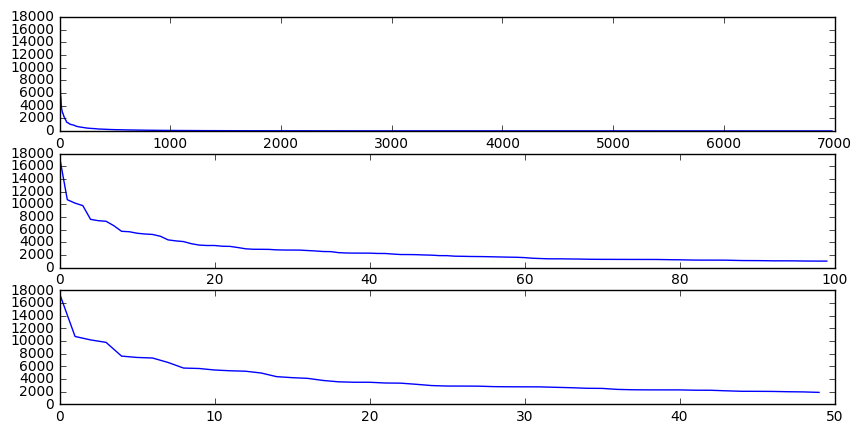

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharey=True)
ax1.plot(cnt)
ax2.plot(cnt[:100])
ax3.plot(cnt[:50])

**How many (distinct) diagnoses a patient has?**

In [19]:
cur.execute('''
    select subject_id, count(distinct icd9_code) as cnt
    from t_diagnoses
    group by subject_id
    order by cnt desc''')
sid, cnt = zip(*cur.fetchall())

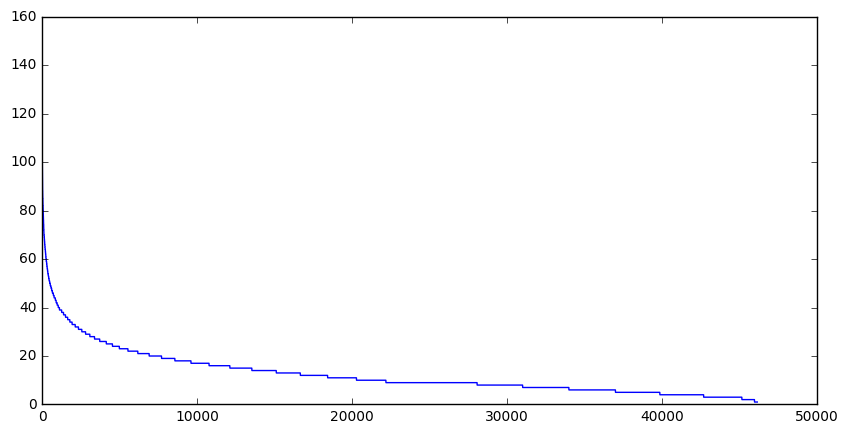

In [20]:
plt.plot(cnt)

### Collect diagnose-icd codes by patient

In [26]:
cur.execute('''
    select subject_id, string_agg(distinct icd9_code, ' ') as diag_icds
    from t_diagnoses
    group by subject_id
    order by subject_id;''')

In [27]:
with open('subject_diag_icds.txt', 'w') as f:
    for sid, icds in tqdm(cur, total=N_SUBJECTS):
        f.write( str(sid) + ', ' + icds + '\n' )

100%|██████████| 46146/46146 [00:00<00:00, 1017326.06it/s]


** let's see how many patients can be covered by top100/top50 diag icds**

In [28]:
cur.execute('''
    select icd9_code, count(distinct subject_id) as cnt
    from t_diagnoses
    group by icd9_code
    order by cnt desc;''')
diag_icds, cnt = zip(*cur.fetchall())

In [29]:
print zip(diag_icds, cnt)[:100]

[('4019', 17510L), ('41401', 10736L), ('42731', 10193L), ('4280', 9802L), ('5849', 7634L), ('2724', 7421L), ('25000', 7332L), ('51881', 6632L), ('5990', 5746L), ('V053', 5678L), ('V290', 5440L), ('2720', 5320L), ('53081', 5246L), ('2859', 4967L), ('486', 4391L), ('2851', 4231L), ('2762', 4120L), ('2449', 3789L), ('496', 3572L), ('99592', 3504L), ('V3000', 3503L), ('0389', 3387L), ('5070', 3362L), ('V5861', 3184L), ('3051', 2982L), ('311', 2907L), ('41071', 2902L), ('5859', 2889L), ('40390', 2814L), ('2761', 2789L), ('2875', 2783L), ('412', 2775L), ('V3001', 2707L), ('4240', 2643L), ('5119', 2554L), ('V1582', 2534L), ('78552', 2376L), ('V4581', 2318L), ('4241', 2302L), ('9971', 2299L), ('42789', 2297L), ('V4582', 2247L), ('7742', 2241L), ('5845', 2154L), ('2760', 2077L), ('5180', 2072L), ('45829', 2055L), ('V5867', 2009L), ('V502', 1978L), ('2767', 1905L), ('4589', 1899L), ('49390', 1814L), ('4168', 1797L), ('5185', 1770L), ('32723', 1758L), ('40391', 1742L), ('78039', 1714L), ('2749', 

In [31]:
n_covered = 0
top_icds = set( diag_icds[:100] )
with open('subject_diag_icds.txt') as f:
    for line in f:
        icds = set(line.split()[1:])
        if len(icds & top_icds)>0:
            n_covered += 1 
print '%d out of %d patients are covered by top 100 icds, coverage=%.8f %%' % \
                (n_covered, N_SUBJECTS, n_covered*100.0/N_SUBJECTS)

44218 out of 46146 patients are covered by top 100 icds, coverage=95.82195640 %


In [32]:
n_covered = 0
top_icds = set( diag_icds[:50] )
with open('subject_diag_icds.txt') as f:
    for line in f:
        icds = set(line.split()[1:])
        if len(icds & top_icds)>0:
            n_covered += 1 
print '%d out of %d patients are covered by top 50 icds, coverage=%.8f %%' % \
                (n_covered, N_SUBJECTS, n_covered*100.0/N_SUBJECTS)

43241 out of 46146 patients are covered by top 50 icds, coverage=93.70476314 %


## Collect notes into csv files

In [33]:
cur.execute('select count(*) from noteevents;')
NB_EVENTNOTES = cur.fetchone()[0]

In [34]:
NB_EVENTNOTES

2078705L

In [35]:
import os
import pandas as pd
DATA_DIR = '/local/XW/DATA/MIMIC/noteevents_by_sid/'
!rm $DATA_DIR/*

rm: cannot remove ‘/local/XW/DATA/MIMIC/noteevents_by_sid//*’: No such file or directory


In [38]:
CSV_HEADER = 'subject_id,hadm_id,chartdate,charttime,storetime,category,description,cgid,iserror,text'

cur.execute('''
    select %s
    from noteevents
    order by subject_id,hadm_id;''' % CSV_HEADER)

_current_sid = -1
_buffer = []


def write_note_to_csv(fname, diry=DATA_DIR, header=CSV_HEADER.split(',')):
    if len(_buffer)==0: return
    fname = os.path.join(diry,fname)
    df = pd.DataFrame(_buffer, columns=header)
    df.to_csv(fname, index=False, header=True)
#     print fname

for line in tqdm(cur, total=NB_EVENTNOTES):
    sid = line[0]
    if sid != _current_sid:
        write_note_to_csv("%d.csv" % _current_sid)
        _current_sid = sid
        _buffer = []    
    _buffer.append(line)

write_note_to_csv("%d.csv" % _current_sid)

100%|██████████| 2078705/2078705 [02:07<00:00, 16334.19it/s]
